In [2]:
from __future__ import annotations

import re
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path

import pandas as pd

pd.set_option('display.max_colwidth', 120)
pd.set_option('display.width', 160)

def resolve_default_log_path() -> Path:
    candidates = [
        Path('logs') / 'test7.log',
        Path('..') / 'logs' / 'test7.log',
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate
    # fallback: search upwards for a 'logs' folder
    here = Path.cwd().resolve()
    for parent in [here, *here.parents]:
        maybe = parent / 'logs' / 'test7.log'
        if maybe.exists():
            return maybe
    return candidates[0]

LOG_PATH = resolve_default_log_path()
LOG_PATH

WindowsPath('../logs/test7.log')

In [3]:
# --- Parsing ---
# Expected format:
# 2025-12-12 01:40:58 - main - INFO     - Starting task 27 - Test 7...

TS_FORMAT = '%Y-%m-%d %H:%M:%S'

def parse_log_lines(path: Path) -> pd.DataFrame:
    rows: list[dict] = []
    for i, raw in enumerate(path.read_text(encoding='utf-8', errors='replace').splitlines(), start=1):
        line = raw.rstrip('\n')
        if not line.strip():
            continue

        # split into: ts, logger, level, message
        parts = line.split(' - ', 3)
        if len(parts) < 4:
            # non-standard line: keep it, but without ts parsing
            rows.append({'line_no': i, 'raw': line, 'ts': pd.NaT, 'logger': None, 'level': None, 'message': line})
            continue

        ts_s, logger, level, message = parts
        try:
            ts = datetime.strptime(ts_s.strip(), TS_FORMAT)
        except ValueError:
            ts = pd.NaT

        rows.append({
            'line_no': i,
            'raw': line,
            'ts': ts,
            'logger': logger.strip(),
            'level': level.strip(),
            'message': message.strip(),
        })

    df = pd.DataFrame(rows)
    df = df.sort_values(['ts', 'line_no'], na_position='last').reset_index(drop=True)
    return df

df = parse_log_lines(LOG_PATH)
df.head(10)

,line_no,raw,ts,logger,level,message
0,1,"2025-12-12 01:40:58 - DB - DEBUG - Task found in MongoDB: 27, status: , updated_at: 2025-12-11 23:40:19.029000,...",2025-12-12 01:40:58,DB,DEBUG,"Task found in MongoDB: 27, status: , updated_at: 2025-12-11 23:40:19.029000, posts: 1, accounts: 11"
1,2,2025-12-12 01:40:58 - main - WARNING - Starting task 27 - Test 7...,2025-12-12 01:40:58,main,WARNING,Starting task 27 - Test 7...
2,3,2025-12-12 01:40:58 - DB - INFO - Upserting task 27 in MongoDB with data: dict_keys(['status']),2025-12-12 01:40:58,DB,INFO,Upserting task 27 in MongoDB with data: dict_keys(['status'])
3,4,2025-12-12 01:40:58 - DB - INFO - Creating run 6fe3d12a-d3a8-4baf-8be0-fd4563733fdf for task 27,2025-12-12 01:40:58,DB,INFO,Creating run 6fe3d12a-d3a8-4baf-8be0-fd4563733fdf for task 27
4,5,"2025-12-12 01:40:58 - DB - DEBUG - Task 27 upsert result: modified=1, upserted_id=None",2025-12-12 01:40:58,DB,DEBUG,"Task 27 upsert result: modified=1, upserted_id=None"
5,6,2025-12-12 01:40:58 - DB - DEBUG - Run 6fe3d12a-d3a8-4baf-8be0-fd4563733fdf created successfully,2025-12-12 01:40:58,DB,DEBUG,Run 6fe3d12a-d3a8-4baf-8be0-fd4563733fdf created successfully
6,7,2025-12-12 01:40:58 - cache - DEBUG - Started cache cleanup task (interval=60s),2025-12-12 01:40:58,cache,DEBUG,Started cache cleanup task (interval=60s)
7,8,2025-12-12 01:40:58 - cache - INFO - TelegramCache initialized scope=process max_size=2000 per_account_ma...,2025-12-12 01:40:58,cache,INFO,TelegramCache initialized scope=process max_size=2000 per_account_max=400 dedup=True
8,9,"2025-12-12 01:40:58 - TelegramCacheRegistry - INFO - Created process-scoped Telegram cache (max_size=2000, per_a...",2025-12-12 01:40:58,TelegramCacheRegistry,INFO,"Created process-scoped Telegram cache (max_size=2000, per_account=400)"
9,10,2025-12-12 01:40:58 - DB - INFO - Loading all accounts from MongoDB.,2025-12-12 01:40:58,DB,INFO,Loading all accounts from MongoDB.


In [4]:
# --- Stage rules ---
# Edit these if your log wording changes. Rules are checked in order; the first match wins.

@dataclass(frozen=True)
class StageRule:
    stage: str
    pattern: re.Pattern
    logger: str | None = None  # optional exact logger match

STAGE_RULES: list[StageRule] = [
    # Start / DB bootstrap
    StageRule('task_bootstrap', re.compile(r'Task found in MongoDB|Starting task\s+\d+|Creating run\s+|Upserting task\s+\d+')),

    # Cache setup
    StageRule('cache_init', re.compile(r'Started cache cleanup task|TelegramCache initialized|Created process-scoped Telegram cache')),

    # Load persisted state
    StageRule('db_load', re.compile(r'Loading all accounts from MongoDB|Loading all posts from MongoDB|Using\s+\d+\s+usable accounts')),

    # Client connect phase
    StageRule('connect_clients', re.compile(r'Connecting clients for\s+\d+ accounts|Initializing client for|Connecting batch\s+\d+\/|Inter-connection batch delay|Client .* started successfully|Connected clients for\s+\d+ accounts')),

    # Post validation
    StageRule('validate_posts', re.compile(r'Validating\s+\d+ posts|Attempting to validate post|Fetched message content for post|Post\s+\d+ validated successfully|Validated\s+\d+ posts')),

    # Palette / action setup
    StageRule('palette_load', re.compile(r'Getting palette from MongoDB|Loaded palette|Loaded reaction palette|Task\s+\d+ proceeding with action')),

    # Worker execution (reading + reaction attempts + inter-reaction sleeps)
    StageRule('workers_run', re.compile(r'Created\s+\d+ workers for task|Worker for .* starting after stagger delay|Client .* using palette|Estimated reading time|Pre-action delay|Attempting emoji|Successfully reacted|Inter-reaction delay|All workers for task')),

    # Disconnect
    StageRule('disconnect_clients', re.compile(r'Disconnecting\s+\d+ clients|Disconnect batch|Inter-disconnect batch delay|Client for .* disconnected|Disconnected\s+\d+ clients')),

    # Final task status / run end
    StageRule('finalize', re.compile(r'Task\s+\d+ completed successfully|Ending run\s+|Ending run .* status|Worker results for task|Task\s+\d+ cache stats')),
]

def assign_stages(df: pd.DataFrame) -> pd.DataFrame:
    current = 'other'
    stages: list[str] = []

    for _, row in df.iterrows():
        msg = (row.get('message') or '')
        logger = row.get('logger')

        matched = None
        for rule in STAGE_RULES:
            if rule.logger is not None and logger != rule.logger:
                continue
            if rule.pattern.search(msg):
                matched = rule.stage
                break

        if matched is not None:
            current = matched
        stages.append(current)

    out = df.copy()
    out['stage'] = stages
    return out

df2 = assign_stages(df)
df2[['ts','logger','level','stage','message']].head(20)

,ts,logger,level,stage,message
0,2025-12-12 01:40:58,DB,DEBUG,task_bootstrap,"Task found in MongoDB: 27, status: , updated_at: 2025-12-11 23:40:19.029000, posts: 1, accounts: 11"
1,2025-12-12 01:40:58,main,WARNING,task_bootstrap,Starting task 27 - Test 7...
2,2025-12-12 01:40:58,DB,INFO,task_bootstrap,Upserting task 27 in MongoDB with data: dict_keys(['status'])
3,2025-12-12 01:40:58,DB,INFO,task_bootstrap,Creating run 6fe3d12a-d3a8-4baf-8be0-fd4563733fdf for task 27
4,2025-12-12 01:40:58,DB,DEBUG,task_bootstrap,"Task 27 upsert result: modified=1, upserted_id=None"
5,2025-12-12 01:40:58,DB,DEBUG,task_bootstrap,Run 6fe3d12a-d3a8-4baf-8be0-fd4563733fdf created successfully
6,2025-12-12 01:40:58,cache,DEBUG,cache_init,Started cache cleanup task (interval=60s)
7,2025-12-12 01:40:58,cache,INFO,cache_init,TelegramCache initialized scope=process max_size=2000 per_account_max=400 dedup=True
8,2025-12-12 01:40:58,TelegramCacheRegistry,INFO,cache_init,"Created process-scoped Telegram cache (max_size=2000, per_account=400)"
9,2025-12-12 01:40:58,DB,INFO,db_load,Loading all accounts from MongoDB.


In [5]:
# --- Timing summary ---
# Attribute the delta between line i and i+1 to stage at line i (wall-clock, not CPU time).

timed = df2.dropna(subset=['ts']).copy()
timed['next_ts'] = timed['ts'].shift(-1)
timed['delta_s'] = (timed['next_ts'] - timed['ts']).dt.total_seconds()
timed['delta_s'] = timed['delta_s'].fillna(0).clip(lower=0)

total_runtime_s = (timed['ts'].iloc[-1] - timed['ts'].iloc[0]).total_seconds() if len(timed) > 1 else 0

by_stage = (
    timed.groupby('stage', dropna=False)
    .agg(
        duration_s=('delta_s', 'sum'),
        lines=('stage', 'size'),
        start_ts=('ts', 'min'),
        end_ts=('ts', 'max'),
    )
    .sort_values('duration_s', ascending=False)
)
by_stage['duration'] = pd.to_timedelta(by_stage['duration_s'], unit='s')
by_stage['pct_runtime'] = (by_stage['duration_s'] / total_runtime_s * 100).round(2) if total_runtime_s else 0

print(f'Total runtime: {pd.to_timedelta(total_runtime_s, unit="s")} ({total_runtime_s:.1f}s)')
by_stage[['duration', 'pct_runtime', 'lines', 'start_ts', 'end_ts']]

Total runtime: 0 days 00:08:42 (522.0s)


,duration,pct_runtime,lines,start_ts,end_ts
stage,,,,,
workers_run,0 days 00:06:35,75.67,317,2025-12-12 01:42:15,2025-12-12 01:48:50
connect_clients,0 days 00:01:07,12.84,186,2025-12-12 01:40:58,2025-12-12 01:42:05
disconnect_clients,0 days 00:00:50,9.58,58,2025-12-12 01:48:50,2025-12-12 01:49:40
validate_posts,0 days 00:00:10,1.92,25,2025-12-12 01:42:05,2025-12-12 01:42:15
cache_init,0 days 00:00:00,0.00,3,2025-12-12 01:40:58,2025-12-12 01:40:58
finalize,0 days 00:00:00,0.00,5,2025-12-12 01:48:50,2025-12-12 01:49:40
db_load,0 days 00:00:00,0.00,5,2025-12-12 01:40:58,2025-12-12 01:40:58
task_bootstrap,0 days 00:00:00,0.00,9,2025-12-12 01:40:58,2025-12-12 01:49:40
palette_load,0 days 00:00:00,0.00,5,2025-12-12 01:42:15,2025-12-12 01:42:15


In [6]:
# --- Stage timeline (consecutive segments) ---
timeline = timed[['ts','stage','message']].copy()
timeline['stage_change'] = timeline['stage'].ne(timeline['stage'].shift(1))
timeline['segment_id'] = timeline['stage_change'].cumsum()
segments = (
    timeline.groupby(['segment_id','stage'])
    .agg(start=('ts','min'), end=('ts','max'), lines=('stage','size'))
    .reset_index(drop=False)
)
segments['duration_s'] = (segments['end'] - segments['start']).dt.total_seconds().clip(lower=0)
segments['duration'] = pd.to_timedelta(segments['duration_s'], unit='s')
segments = segments.sort_values('start').reset_index(drop=True)
segments[['stage','start','end','duration','lines']].head(50)

,stage,start,end,duration,lines
0,task_bootstrap,2025-12-12 01:40:58,2025-12-12 01:40:58,0 days 00:00:00,6
1,cache_init,2025-12-12 01:40:58,2025-12-12 01:40:58,0 days 00:00:00,3
2,db_load,2025-12-12 01:40:58,2025-12-12 01:40:58,0 days 00:00:00,5
3,connect_clients,2025-12-12 01:40:58,2025-12-12 01:42:05,0 days 00:01:07,186
4,validate_posts,2025-12-12 01:42:05,2025-12-12 01:42:15,0 days 00:00:10,25
5,palette_load,2025-12-12 01:42:15,2025-12-12 01:42:15,0 days 00:00:00,5
6,workers_run,2025-12-12 01:42:15,2025-12-12 01:48:50,0 days 00:06:35,317
7,finalize,2025-12-12 01:48:50,2025-12-12 01:48:50,0 days 00:00:00,2
8,disconnect_clients,2025-12-12 01:48:50,2025-12-12 01:49:40,0 days 00:00:50,58
9,task_bootstrap,2025-12-12 01:49:40,2025-12-12 01:49:40,0 days 00:00:00,3


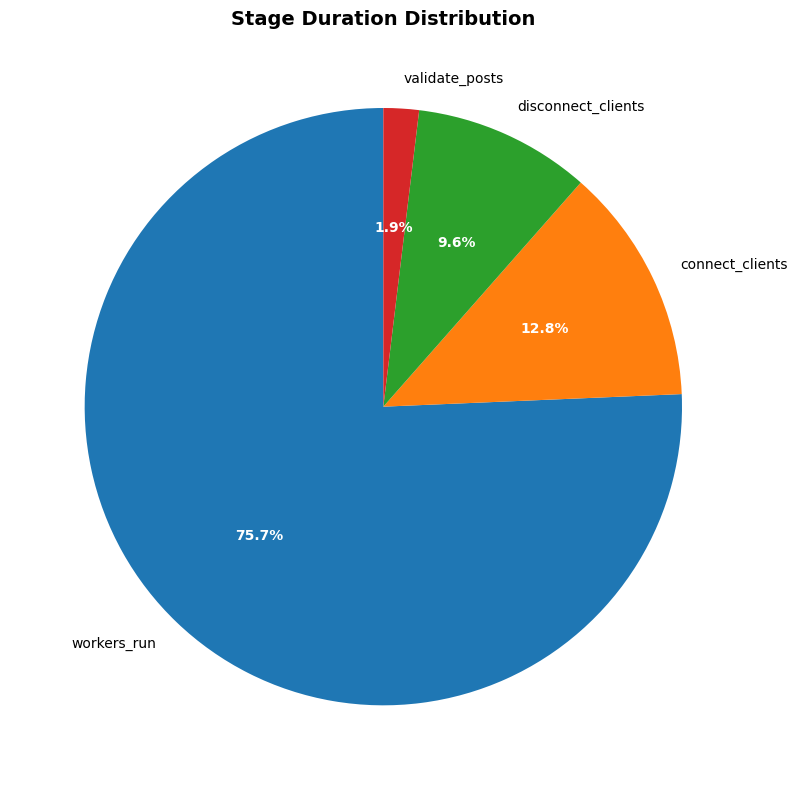

In [7]:
import matplotlib.pyplot as plt

# Create a pie chart of stage durations
fig, ax = plt.subplots(figsize=(10, 8))

# Filter out stages with 0 duration for better visualization
stage_data = by_stage[by_stage['duration_s'] > 0].copy()

# Create the pie chart
wedges, texts, autotexts = ax.pie(
    stage_data['duration_s'], 
    labels=stage_data.index,
    autopct='%1.1f%%',
    startangle=90
)

# Customize the chart
ax.set_title('Stage Duration Distribution', fontsize=14, fontweight='bold')

# Make percentage text more readable
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

,duration,duration_s,lines
logger,,,
+15343566899,0 days 00:00:26,26.0,27
+17794794156,0 days 00:00:24,24.0,27
+17793377154,0 days 00:00:23,23.0,27
+380992310062,0 days 00:00:23,23.0,30
+18126491110,0 days 00:00:22,22.0,28
+17123609186,0 days 00:00:20,20.0,27
+17793841166,0 days 00:00:17,17.0,27
+17795992414,0 days 00:00:16,16.0,28
+15348001361,0 days 00:00:15,15.0,27


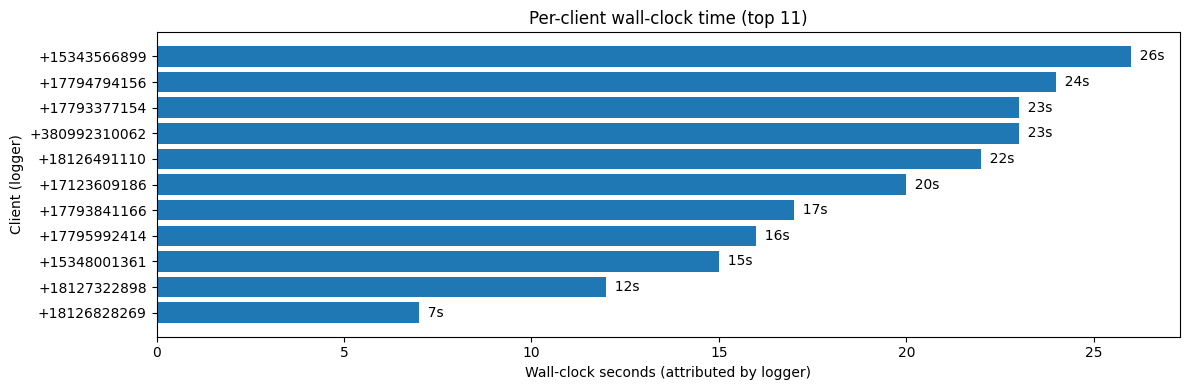

In [8]:
# --- Per-client timing (bar chart) ---
# We treat phone-number loggers as "clients" and attribute deltas between lines to the logger at the first line.

# Extract phone loggers like +123456789
client_timed = timed.copy()
client_timed['is_client_logger'] = client_timed['logger'].astype(str).str.match(r'^\+\d+$')
client_only = client_timed[client_timed['is_client_logger']].copy()

if client_only.empty:
    print('No client loggers found (phone-number logger names).')
else:
    per_client = (
        client_only.groupby('logger', dropna=False)
        .agg(duration_s=('delta_s', 'sum'), lines=('logger', 'size'))
        .sort_values('duration_s', ascending=False)
    )
    per_client['duration'] = pd.to_timedelta(per_client['duration_s'], unit='s')
    display(per_client[['duration', 'duration_s', 'lines']].head(25))

    # Plot top N clients by wall-clock time
    top_n = 15
    plot_df = per_client.head(top_n).iloc[::-1]  # reverse for nicer horizontal bar ordering
    
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(12, max(4, 0.35 * len(plot_df))))
    ax.barh(plot_df.index.astype(str), plot_df['duration_s'])
    ax.set_xlabel('Wall-clock seconds (attributed by logger)')
    ax.set_ylabel('Client (logger)')
    ax.set_title(f'Per-client wall-clock time (top {min(top_n, len(per_client))})')
    
    # Add labels
    for y, v in enumerate(plot_df['duration_s']):
        ax.text(v, y, f'  {v:.0f}s', va='center')
    
    plt.tight_layout()
    plt.show()